In [1]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [3]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import *
from causalml.propensity import calibrate

import importlib
print(importlib.metadata.version('causalml') )

0.15.1


In [4]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

### Generating Synthetic Data

In [5]:
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)
(
    X_train,
    X_test,
    y_train,
    y_test,
    e_train,
    e_test,
    treatment_train,
    treatment_test,
    tau_train,
    tau_test,
    b_train,
    b_test,
) = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)


### Calculating Individual Treatment Effect (ITE/CATE)

In [6]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

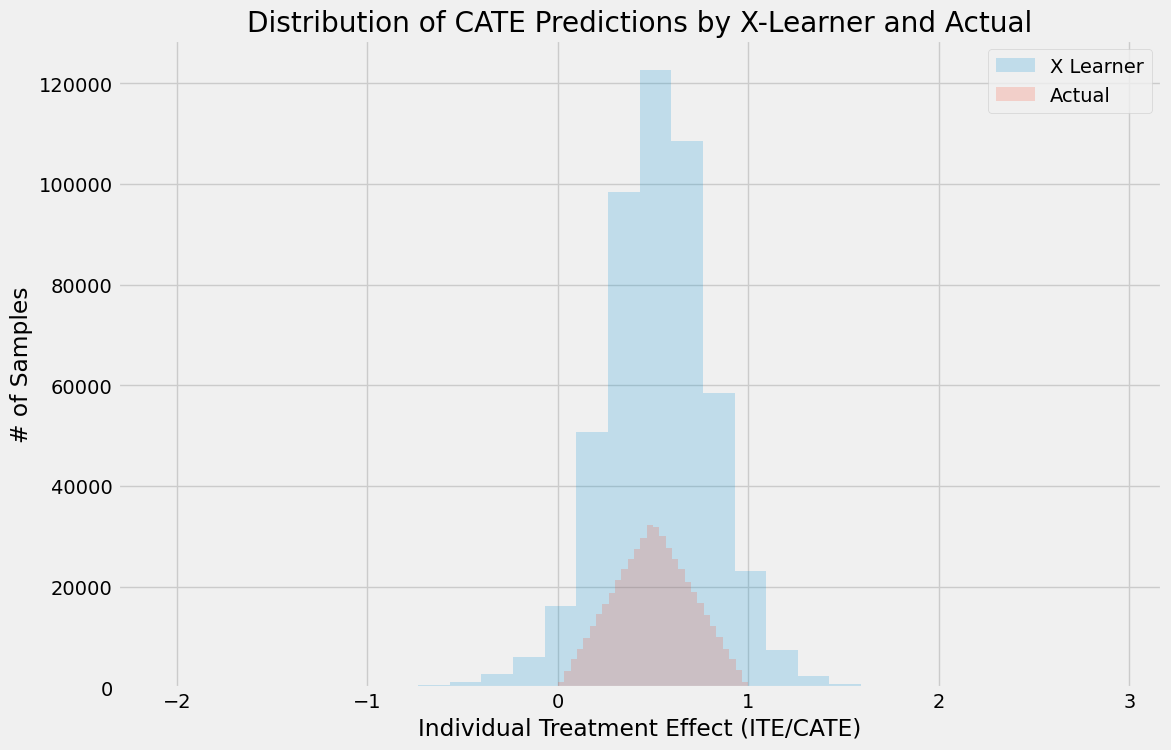

In [7]:
alpha = 0.2
bins = 30
plt.figure(figsize=(12, 8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label="X Learner")
plt.hist(tau_test, alpha=alpha, bins=bins, label="Actual")

plt.title("Distribution of CATE Predictions by X-Learner and Actual")
plt.xlabel("Individual Treatment Effect (ITE/CATE)")
plt.ylabel("# of Samples")
_ = plt.legend()


### Validating CATE without TMLE

In [8]:
df = pd.DataFrame({"y": y_test, "w": treatment_test, "tau": tau_test, "X-Learner": cate_x_test, "Actual": tau_test})


#### Uplift Curve With Ground Truth

If the true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model’s CATE estimate

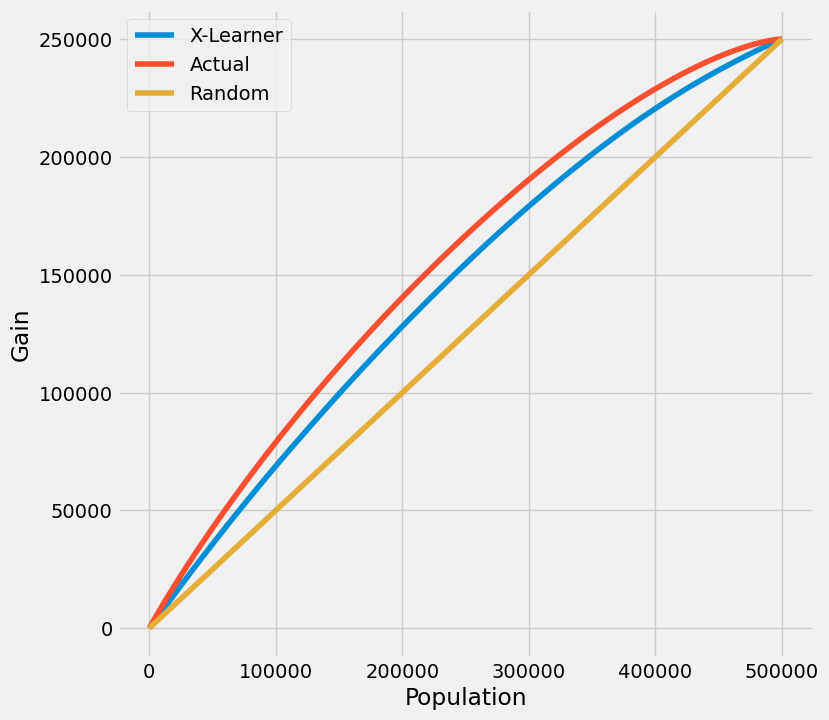

In [9]:
plot(df, outcome_col="y", treatment_col="w", treatment_effect_col="tau")


#### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model’s CATE estimate.

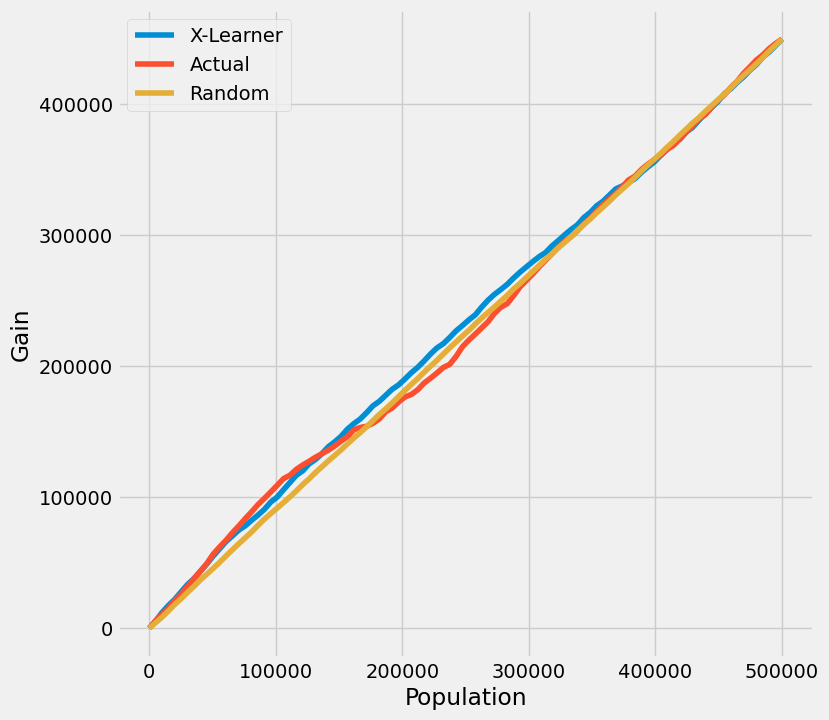

In [10]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

#### Uplift Curve with TMLE as Ground Truth

By using TMLE as a proxy of the ground truth, the uplift curves of X-learner and the ground truth become close to the original using the ground truth.

In [11]:
n_fold = 5
kf = KFold(n_splits=n_fold)

In [12]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'p': e_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [13]:
inference_cols = []
for i in range(X_test.shape[1]):
    col = "col_" + str(i)
    df[col] = X_test[:, i]
    inference_cols.append(col)


In [14]:
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,4.407529,0,0.522130,0.924762,0.908533,0.925691,0.891375,0.397142,0.850068,0.965143,0.541880,0.913780,0.249594,0.301781,0.690078
1,-9.426841,0,0.415859,0.380050,0.387162,0.271509,0.502816,0.047616,0.300345,0.594226,0.220859,0.580430,0.210916,0.606194,0.967513
2,-6.483263,1,0.656551,0.626885,0.583787,0.247897,0.919676,0.264838,0.125027,0.735740,0.764537,0.811960,0.549104,0.015257,0.203025
3,-5.252437,1,0.900000,0.603527,0.648030,0.583824,0.712236,0.221484,0.488724,0.746866,0.524432,0.410449,0.347097,0.313761,0.569334
4,2.170910,0,0.548195,0.760645,0.532984,0.848241,0.217727,0.042324,0.101219,0.879939,0.621080,0.593689,0.713775,0.585164,0.156987


In [15]:
tmle_df = get_tmlegain(
    df,
    inference_col=inference_cols,
    outcome_col="y",
    treatment_col="w",
    p_col="p",
    n_segment=5,
    cv=kf,
    calibrate_propensity=True,
    ci=False,
)


In [16]:
tmle_df

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
0.2,0.139379,0.175061,0.101557
0.4,0.259054,0.289851,0.203114
0.6,0.377406,0.404663,0.304671
0.8,0.453065,0.479998,0.406229
1.0,0.507786,0.507786,0.507786


### AUUC score

In [17]:
auuc_score(
    df,
    tmle=True,
    inference_col=inference_cols,
    outcome_col="y",
    treatment_col="w",
    p_col="p",
    n_segment=5,
    cv=kf,
    calibrate_propensity=True,
    ci=False,
)


X-Learner    0.289448
Actual       0.309560
Random       0.253893
dtype: float64

#### Uplift Curve with CI

In [18]:
tmle_df = get_tmlegain(
    df,
    inference_col=inference_cols,
    outcome_col="y",
    treatment_col="w",
    p_col="p",
    n_segment=5,
    cv=kf,
    calibrate_propensity=True,
    ci=True,
)


In [19]:
tmle_df

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,0.139379,0.175061,0.121351,0.155884,0.157407,0.194238,0.101557
0.4,0.259054,0.289851,0.223876,0.252701,0.294232,0.327000,0.203114
0.6,0.377406,0.404663,0.325653,0.353458,0.429160,0.455867,0.304671
0.8,0.453065,0.479998,0.385222,0.413773,0.520909,0.546223,0.406229
1.0,0.507786,0.507786,0.469510,0.469510,0.546061,0.546061,0.507786


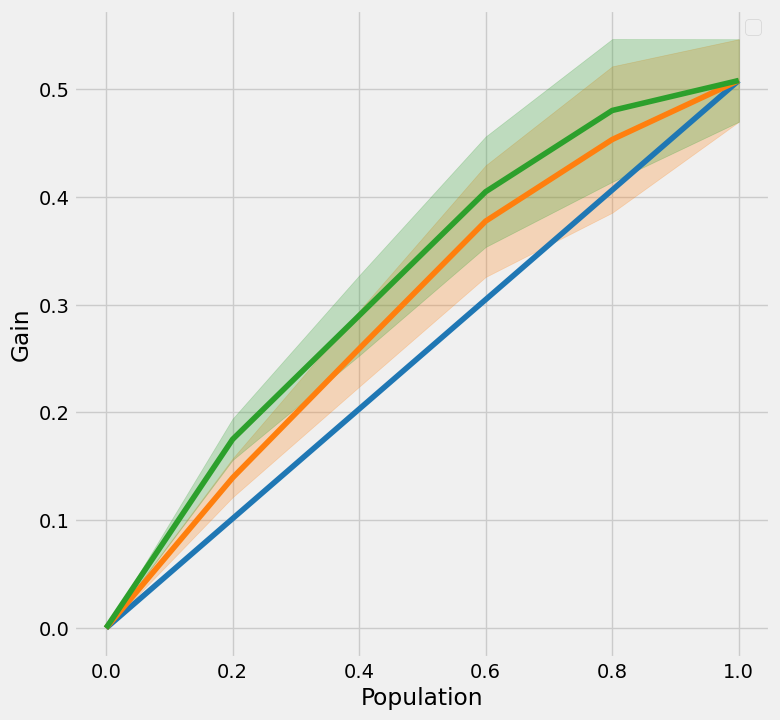

In [20]:
plot_tmlegain(
    df,
    inference_col=inference_cols,
    outcome_col="y",
    treatment_col="w",
    p_col="p",
    n_segment=5,
    cv=kf,
    calibrate_propensity=True,
    ci=True,
)


In [ ]:
plot(
    df,
    kind="gain",
    tmle=True,
    inference_col=inference_cols,
    outcome_col="y",
    treatment_col="w",
    p_col="p",
    n_segment=5,
    cv=kf,
    calibrate_propensity=True,
    ci=True,
)


### Qini Score

In [ ]:
qini_score(
    df,
    tmle=True,
    inference_col=inference_cols,
    outcome_col="y",
    treatment_col="w",
    p_col="p",
    n_segment=5,
    cv=kf,
    calibrate_propensity=True,
    ci=False,
)


In [ ]:
qini = get_tmleqini(
    df,
    inference_col=inference_cols,
    outcome_col="y",
    treatment_col="w",
    p_col="p",
    n_segment=5,
    cv=kf,
    calibrate_propensity=True,
    ci=True,
)


In [ ]:
qini

In [ ]:
plot_tmleqini(
    df,
    inference_col=inference_cols,
    outcome_col="y",
    treatment_col="w",
    p_col="p",
    n_segment=5,
    cv=kf,
    calibrate_propensity=True,
    ci=True,
)


In [ ]:
plot(
    df,
    kind="qini",
    tmle=True,
    inference_col=inference_cols,
    outcome_col="y",
    treatment_col="w",
    p_col="p",
    n_segment=5,
    cv=kf,
    calibrate_propensity=True,
    ci=True,
)
